In [1]:
import sys

sys.path.insert(0, '..')

import shutil
import os
import uuid
from bio_check.data_model import MongoDbConnector
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import os 

_outs = './test_outputs'
if os.path.exists(_outs):
    shutil.rmtree(_outs)


def jobid(): return str(uuid.uuid4())


load_dotenv("../bio_check/.env")
uri = os.getenv("MONGO_DB_URI")
omex_source_dir = './examples/sbml-core'
omex_name = 'Elowitz-Nature-2000-Repressilator.omex'
omex_fp = os.path.join(omex_source_dir, omex_name)
out_dir = './test_outputs'
simulators = ['amici', 'copasi', 'tellurium']
spec_name = 'cI mRNA'
job_id = jobid()
db_connector = MongoDbConnector(client=MongoClient(uri), database_id="service_requests")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def generate_audio_waveform(frequencies, amplitudes, duration, sampling_rate, noise_level):
    """
    Generate a complex noisy waveform that resembles audio.

    Parameters:
    - frequencies (list of float): List of frequencies for the sine waves in Hz.
    - amplitudes (list of float): List of amplitudes for the sine waves.
    - duration (float): Duration of the wave in seconds.
    - sampling_rate (float): Sampling rate in samples per second (Hz).
    - noise_level (float): Standard deviation of the Gaussian noise to be added.

    Returns:
    - np.ndarray: Noisy waveform as a NumPy array.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    waveform = np.zeros_like(t)
    
    for freq, amp in zip(frequencies, amplitudes):
        waveform += amp * np.sin(2 * np.pi * freq * t)
    
    noise = noise_level * np.random.normal(size=t.shape)
    noisy_waveform = waveform + noise
    
    return noisy_waveform

def perform_fft_and_display_frequencies(signal, sampling_rate, threshold=0.1):
    """
    Perform FFT on the signal and display the fundamental frequencies.

    Parameters:
    - signal (np.ndarray): Input signal.
    - sampling_rate (float): Sampling rate of the signal.
    - threshold (float): Threshold for determining significant frequencies.
    """
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N//2]

    plt.figure(figsize=(12, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Identify significant frequencies
    amplitudes = 2.0/N * np.abs(yf[:N//2])
    significant_frequencies = xf[amplitudes > threshold]
    significant_amplitudes = amplitudes[amplitudes > threshold]

    print("Significant Frequencies:")
    for freq, amp in zip(significant_frequencies, significant_amplitudes):
        print(f"Frequency: {freq:.2f} Hz, Amplitude: {amp:.2f}")

# Example usage
if __name__ == "__main__":
    frequencies = [100, 200, 300, 400]  # Frequencies in Hz
    amplitudes = [1.0, 0.5, 0.25, 0.125]  # Amplitudes of the waves
    duration = 2.0  # Duration in seconds
    sampling_rate = 44100  # Sampling rate in Hz
    noise_level = 0.05  # Noise level (standard deviation of the noise)

    wave = generate_audio_waveform(frequencies, amplitudes, duration, sampling_rate, noise_level)
    
    # Perform FFT and display frequencies
    perform_fft_and_display_frequencies(wave, sampling_rate)


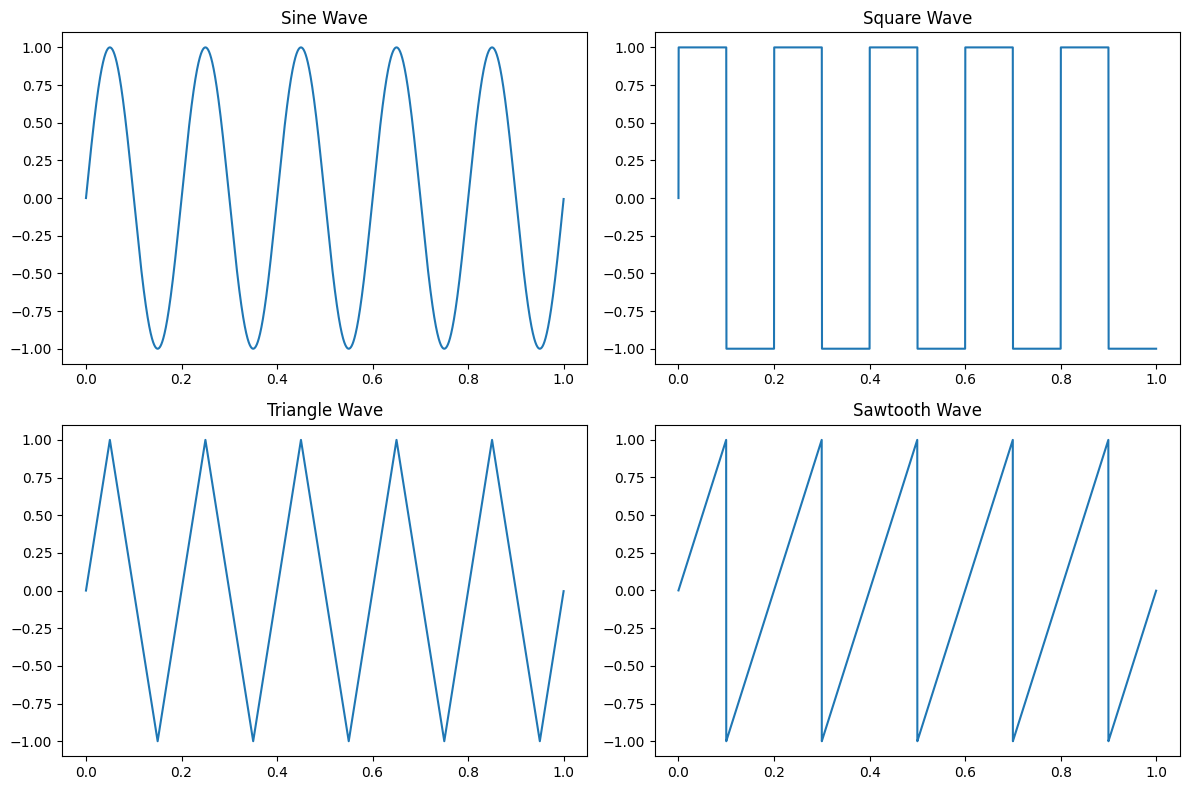

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Jetson.GPIO as GPIO
import time

class FunctionGenerator:
    def __init__(self, amplitude=1.0, frequency=1.0, phase=0.0, sample_rate=1000):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase = phase
        self.sample_rate = sample_rate
    
    def generate_time_array(self, duration):
        return np.linspace(0, duration, int(self.sample_rate * duration), endpoint=False)
    
    def sine_wave(self, duration):
        t = self.generate_time_array(duration)
        return t, self.amplitude * np.sin(2 * np.pi * self.frequency * t + self.phase)
    
    def square_wave(self, duration):
        t = self.generate_time_array(duration)
        return t, self.amplitude * np.sign(np.sin(2 * np.pi * self.frequency * t + self.phase))
    
    def triangle_wave(self, duration):
        t = self.generate_time_array(duration)
        return t, self.amplitude * (2 * np.arcsin(np.sin(2 * np.pi * self.frequency * t + self.phase)) / np.pi)
    
    def sawtooth_wave(self, duration):
        t = self.generate_time_array(duration)
        return t, self.amplitude * (2 * (t * self.frequency - np.floor(t * self.frequency + 0.5)))

    def pwm_output(self, duration, waveform, pin=12):
        GPIO.setmode(GPIO.BOARD)
        GPIO.setup(pin, GPIO.OUT)
        pwm = GPIO.PWM(pin, self.sample_rate)
        pwm.start(0)
        
        t, data = waveform(duration)
        
        for i in range(len(data)):
            duty_cycle = (data[i] + self.amplitude) / (2 * self.amplitude) * 100
            pwm.ChangeDutyCycle(duty_cycle)
            time.sleep(1 / self.sample_rate)
        
        pwm.stop()
        GPIO.cleanup()

# Example usage
if __name__ == "__main__":
    fg = FunctionGenerator(amplitude=1.0, frequency=5.0, sample_rate=5000)
    duration = 1.0  # seconds
    
    # Generate and output waveforms
    fg.pwm_output(duration, fg.sine_wave, pin=12)
    
    # Optional: Generate waveforms and plot them
    t_sine, sine_wave = fg.sine_wave(duration)
    t_square, square_wave = fg.square_wave(duration)
    t_triangle, triangle_wave = fg.triangle_wave(duration)
    t_sawtooth, sawtooth_wave = fg.sawtooth_wave(duration)
    
    # Plot waveforms
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(t_sine, sine_wave)
    plt.title("Sine Wave")
    
    plt.subplot(2, 2, 2)
    plt.plot(t_square, square_wave)
    plt.title("Square Wave")
    
    plt.subplot(2, 2, 3)
    plt.plot(t_triangle, triangle_wave)
    plt.title("Triangle Wave")
    
    plt.subplot(2, 2, 4)
    plt.plot(t_sawtooth, sawtooth_wave)
    plt.title("Sawtooth Wave")
    
    plt.tight_layout()
    plt.show()
